# Solving Multi-Agent Reinforcement Learning Problem by DRL Method(DDPG)


We chose DDPG Algorithm. DDPG is a policy-based method of DRL using Actor/Critic Algorithm and can be useful for both discrete and continous tasks.

Detailed DDPG Algorithm is below.

![ddpg_algorithm](assets/ddpg_algorithm.png)

* Reference : [DDPG paper](https://arxiv.org/abs/1509.02971).

---
In this notebook, we will implement a MADDPG agent with Unity ML-Agents Tennis environment.

### 1. Import the Necessary Packages

In [1]:
import torch
import random
import numpy as np
from collections import deque
from ddpg_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Import the Necesaary Packages to start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

### 3. Instantiate the Environment
Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
brain_name

'TennisBrain'

In [6]:
brain

### 4. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 5. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [9]:
for i in range(1, 11):                                      # play game for 10 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.09000000171363354
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0
Score (max over agents) from episode 6: 0.0
Score (max over agents) from episode 7: 0.0
Score (max over agents) from episode 8: 0.09000000357627869
Score (max over agents) from episode 9: 0.0
Score (max over agents) from episode 10: 0.0


When finished, you can close the environment.

In [ ]:
env.close()

### 6. Train our own Agent

Now it's our turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

### Set the Training Parameters

* num_episodes (int): maximum number of training episodes
* episode_scores (float): list to record the scores obtained from each episode
* average_score_window (int): the window size employed for calculating the average score (e.g. 100)
* solved_score (float): the average score required for the environment to be considered solved


In [10]:
num_episodes=10000
episode_scores = []
average_score_window = 100      
solved_score = 0.5   

Before running the next code cell, check with the code in `ddpg_agent.py` and `model.py`.
- Check a neural network architecture in `model.py`. This file is to define our own DDPG Model!
- We changed ['Simple Continuous Control with DRL' Project](https://github.com/parksurk/drl_policy-based_methods) code to use two DDPG Agents(agent1, agent2) which received its own observations and collaborative agent's observations also. so state obervations is 24*2=48.
- We changed OUNOise Function parameters(sigma, sigma_min, sigma_decay) to maximize exploration during early stages of training time. this modification leads good results in faster and more robust learning.

### Create a DDPG Agents from the Agent Class in ddpg_agent.py

A DDPG agent initialized with the following parameters.

* state_size (int): dimension of each state (required)
* action_size (int): dimension of each action (required)
* num_agents (int): number of agents in the unity environment
* seed (int): random seed for initializing training point (default = 0)

In [11]:
agent1 = Agent(state_size=48, action_size=action_size, num_agents=1, random_seed=0)

In [12]:
agent2 = Agent(state_size=48, action_size=action_size, num_agents=1, random_seed=0)

### DDPG Model Architecture for Agent1

In [13]:
agent1.actor_local

Actor(
  (fc1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [14]:
agent1.actor_target

Actor(
  (fc1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [15]:
agent1.critic_local

Critic(
  (fcs1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=258, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [16]:
agent1.critic_target

Critic(
  (fcs1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=258, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

### DDPG Model Architecture for Agent2

In [17]:
agent2.actor_local

Actor(
  (fc1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [18]:
agent2.actor_target

Actor(
  (fc1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)

In [19]:
agent2.critic_local

Critic(
  (fcs1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=258, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

In [20]:
agent2.critic_target

Critic(
  (fcs1): Linear(in_features=48, out_features=256, bias=True)
  (fc2): Linear(in_features=258, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

### Chosen Hyperparamters
* BUFFER_SIZE = int(5e5)  # replay buffer size
* BATCH_SIZE = 128        # minibatch size
* GAMMA = 0.99            # discount factor
* TAU = 5e-3              # for soft update of target parameters
* LR_ACTOR = 1e-3         # learning rate of the actor 
* LR_CRITIC = 1e-3        # learning rate of the critic
* WEIGHT_DECAY = 0.0      # L2 weight decay

### Train the Agent with MADDPG

Run the code cell below to train the agent from scratch.

In [21]:
def maddpg(n_episodes=1000, print_every=100):
    # loop from n_episodes
    for i_episode in range(1, n_episodes+1):

        # Reset the Unity ML-agents environment at the beginning of each episode
        env_info = env.reset(train_mode=True)[brain_name]     

        # Get initial state of the Unity ML-agents environment and reshape
        states = env_info.vector_observations
        states = np.reshape(states, (1, 48))

        # Reset the training agent for new episode
        agent1.reset()
        agent2.reset()

        # Set the initial episode score to zero.
        agent_scores = np.zeros(num_agents)

        # Run the episode training loop;
        # At each loop step take an action as a function of the current state observations
        # Update the Agents Actor and Critic networks, based on the next_state and reward received 
        # If environment episode is done, exit loop...
        # Otherwise repeat until done == true 
        while True:
            # Determine actions for the Unity ML-agents from current sate
            actions1 = agent1.act(states, add_noise=True)
            actions2 = agent2.act(states, add_noise=True)

            # Send the actions to the Unity ML-agents in the environment and receive environment information
            actions = np.concatenate((actions1, actions2), axis=0) 
            actions = np.reshape(actions, (1, 4))
            env_info = env.step(actions)[brain_name]        

            next_states = env_info.vector_observations   # Get the next states for each unity agent in the environment
            next_states = np.reshape(next_states, (1, 48))
            rewards = env_info.rewards                   # Get the rewards for each the Unity ML-agent in the environment
            dones = env_info.local_done                  # See if episode has finished for each the Unity ML-agent in the environment

            #Send (S, A, R, S') info to the training agent for Replay Buffer (memory) and network updates
            agent1.step(states, actions1, rewards[0], next_states, dones[0])
            agent2.step(states, actions2, rewards[1], next_states, dones[1])
            
            # Set new states to current states for determining next actions
            states = next_states

            # Update episode score for each the Unity ML-agent
            agent_scores += rewards

            # If any the Unity ML-agent indicates that the episode is done, 
            # then exit episode loop, to begin new episode
            if np.any(dones):
                break

        # Add episode score to Scores and...
        # Calculate mean score over last 100 episodes 
        # Mean score is calculated over current episodes until i_episode > 100
        episode_scores.append(np.max(agent_scores))
        average_score = np.mean(episode_scores[i_episode-min(i_episode,average_score_window):i_episode+1])

        # Print current and average score
        print('\nEpisode {}\tEpisode Score: {:.3f}\tAverage Score: {:.3f}'.format(i_episode, episode_scores[i_episode-1], average_score), end="")

        # Save checkpoint trained Actor and Critic network weights after each episode for agent1
        an_filename = "checkpoint_actor1.pth"
        torch.save(agent1.actor_local.state_dict(), an_filename)
        cn_filename = "checkpoint_critic1.pth"
        torch.save(agent1.critic_local.state_dict(), cn_filename)
        
        # Save checkpoint trained Actor and Critic network weights after each episode for agent2
        an_filename = "checkpoint_actor2.pth"
        torch.save(agent2.actor_local.state_dict(), an_filename)
        cn_filename = "checkpoint_critic2.pth"
        torch.save(agent2.critic_local.state_dict(), cn_filename)

        # Check to see if the task is solved (i.e,. avearge_score > solved_score over 100 episodes). 
        # If yes, save the network weights and scores and end training.
        if i_episode > 100 and average_score >= solved_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, average_score))
            break
    return episode_scores

scores = maddpg(n_episodes=num_episodes)


Episode 1	Episode Score: 0.000	Average Score: 0.000
Episode 2	Episode Score: 0.000	Average Score: 0.000
Episode 3	Episode Score: 0.000	Average Score: 0.000
Episode 4	Episode Score: 0.000	Average Score: 0.000
Episode 5	Episode Score: 0.000	Average Score: 0.000
Episode 6	Episode Score: 0.000	Average Score: 0.000
Episode 7	Episode Score: 0.000	Average Score: 0.000
Episode 8	Episode Score: 0.000	Average Score: 0.000
Episode 9	Episode Score: 0.000	Average Score: 0.000
Episode 10	Episode Score: 0.000	Average Score: 0.000
Episode 11	Episode Score: 0.000	Average Score: 0.000
Episode 12	Episode Score: 0.000	Average Score: 0.000
Episode 13	Episode Score: 0.000	Average Score: 0.000
Episode 14	Episode Score: 0.000	Average Score: 0.000
Episode 15	Episode Score: 0.000	Average Score: 0.000
Episode 16	Episode Score: 0.000	Average Score: 0.000
Episode 17	Episode Score: 0.000	Average Score: 0.000
Episode 18	Episode Score: 0.100	Average Score: 0.006
Episode 19	Episode Score: 0.000	Average Score: 0.005
E

Episode 154	Episode Score: 0.000	Average Score: 0.001
Episode 155	Episode Score: 0.000	Average Score: 0.001
Episode 156	Episode Score: 0.000	Average Score: 0.001
Episode 157	Episode Score: 0.000	Average Score: 0.001
Episode 158	Episode Score: 0.090	Average Score: 0.002
Episode 159	Episode Score: 0.000	Average Score: 0.001
Episode 160	Episode Score: 0.000	Average Score: 0.001
Episode 161	Episode Score: 0.000	Average Score: 0.001
Episode 162	Episode Score: 0.000	Average Score: 0.001
Episode 163	Episode Score: 0.000	Average Score: 0.001
Episode 164	Episode Score: 0.000	Average Score: 0.001
Episode 165	Episode Score: 0.000	Average Score: 0.001
Episode 166	Episode Score: 0.000	Average Score: 0.001
Episode 167	Episode Score: 0.000	Average Score: 0.001
Episode 168	Episode Score: 0.000	Average Score: 0.001
Episode 169	Episode Score: 0.000	Average Score: 0.001
Episode 170	Episode Score: 0.000	Average Score: 0.001
Episode 171	Episode Score: 0.000	Average Score: 0.001
Episode 172	Episode Score: 0

Episode 305	Episode Score: 0.000	Average Score: 0.006
Episode 306	Episode Score: 0.000	Average Score: 0.006
Episode 307	Episode Score: 0.100	Average Score: 0.007
Episode 308	Episode Score: 0.000	Average Score: 0.006
Episode 309	Episode Score: 0.000	Average Score: 0.006
Episode 310	Episode Score: 0.000	Average Score: 0.006
Episode 311	Episode Score: 0.000	Average Score: 0.006
Episode 312	Episode Score: 0.000	Average Score: 0.005
Episode 313	Episode Score: 0.000	Average Score: 0.005
Episode 314	Episode Score: 0.000	Average Score: 0.005
Episode 315	Episode Score: 0.000	Average Score: 0.005
Episode 316	Episode Score: 0.100	Average Score: 0.006
Episode 317	Episode Score: 0.000	Average Score: 0.006
Episode 318	Episode Score: 0.000	Average Score: 0.006
Episode 319	Episode Score: 0.100	Average Score: 0.007
Episode 320	Episode Score: 0.100	Average Score: 0.008
Episode 321	Episode Score: 0.100	Average Score: 0.009
Episode 322	Episode Score: 0.000	Average Score: 0.009
Episode 323	Episode Score: 0

Episode 456	Episode Score: 0.000	Average Score: 0.012
Episode 457	Episode Score: 0.000	Average Score: 0.012
Episode 458	Episode Score: 0.000	Average Score: 0.012
Episode 459	Episode Score: 0.000	Average Score: 0.012
Episode 460	Episode Score: 0.000	Average Score: 0.012
Episode 461	Episode Score: 0.000	Average Score: 0.012
Episode 462	Episode Score: 0.000	Average Score: 0.012
Episode 463	Episode Score: 0.000	Average Score: 0.011
Episode 464	Episode Score: 0.000	Average Score: 0.011
Episode 465	Episode Score: 0.000	Average Score: 0.011
Episode 466	Episode Score: 0.000	Average Score: 0.011
Episode 467	Episode Score: 0.000	Average Score: 0.010
Episode 468	Episode Score: 0.000	Average Score: 0.010
Episode 469	Episode Score: 0.000	Average Score: 0.010
Episode 470	Episode Score: 0.000	Average Score: 0.010
Episode 471	Episode Score: 0.000	Average Score: 0.010
Episode 472	Episode Score: 0.000	Average Score: 0.010
Episode 473	Episode Score: 0.000	Average Score: 0.009
Episode 474	Episode Score: 0

Episode 607	Episode Score: 0.000	Average Score: 0.027
Episode 608	Episode Score: 0.000	Average Score: 0.027
Episode 609	Episode Score: 0.000	Average Score: 0.027
Episode 610	Episode Score: 0.100	Average Score: 0.028
Episode 611	Episode Score: 0.000	Average Score: 0.027
Episode 612	Episode Score: 0.200	Average Score: 0.028
Episode 613	Episode Score: 0.000	Average Score: 0.028
Episode 614	Episode Score: 0.000	Average Score: 0.028
Episode 615	Episode Score: 0.000	Average Score: 0.028
Episode 616	Episode Score: 0.100	Average Score: 0.029
Episode 617	Episode Score: 0.000	Average Score: 0.029
Episode 618	Episode Score: 0.090	Average Score: 0.030
Episode 619	Episode Score: 0.000	Average Score: 0.030
Episode 620	Episode Score: 0.100	Average Score: 0.031
Episode 621	Episode Score: 0.000	Average Score: 0.031
Episode 622	Episode Score: 0.000	Average Score: 0.031
Episode 623	Episode Score: 0.000	Average Score: 0.031
Episode 624	Episode Score: 0.000	Average Score: 0.031
Episode 625	Episode Score: 0

Episode 758	Episode Score: 0.100	Average Score: 0.046
Episode 759	Episode Score: 0.100	Average Score: 0.045
Episode 760	Episode Score: 0.000	Average Score: 0.045
Episode 761	Episode Score: 0.100	Average Score: 0.046
Episode 762	Episode Score: 0.000	Average Score: 0.045
Episode 763	Episode Score: 0.100	Average Score: 0.045
Episode 764	Episode Score: 0.090	Average Score: 0.045
Episode 765	Episode Score: 0.000	Average Score: 0.044
Episode 766	Episode Score: 0.100	Average Score: 0.045
Episode 767	Episode Score: 0.100	Average Score: 0.046
Episode 768	Episode Score: 0.000	Average Score: 0.045
Episode 769	Episode Score: 0.000	Average Score: 0.044
Episode 770	Episode Score: 0.090	Average Score: 0.044
Episode 771	Episode Score: 0.100	Average Score: 0.045
Episode 772	Episode Score: 0.100	Average Score: 0.045
Episode 773	Episode Score: 0.000	Average Score: 0.044
Episode 774	Episode Score: 0.100	Average Score: 0.044
Episode 775	Episode Score: 0.090	Average Score: 0.045
Episode 776	Episode Score: 0

Episode 909	Episode Score: 0.090	Average Score: 0.096
Episode 910	Episode Score: 0.100	Average Score: 0.096
Episode 911	Episode Score: 0.100	Average Score: 0.096
Episode 912	Episode Score: 0.100	Average Score: 0.096
Episode 913	Episode Score: 0.100	Average Score: 0.096
Episode 914	Episode Score: 0.100	Average Score: 0.096
Episode 915	Episode Score: 0.100	Average Score: 0.096
Episode 916	Episode Score: 0.100	Average Score: 0.096
Episode 917	Episode Score: 0.100	Average Score: 0.096
Episode 918	Episode Score: 0.100	Average Score: 0.096
Episode 919	Episode Score: 0.100	Average Score: 0.096
Episode 920	Episode Score: 0.090	Average Score: 0.096
Episode 921	Episode Score: 0.100	Average Score: 0.096
Episode 922	Episode Score: 0.100	Average Score: 0.097
Episode 923	Episode Score: 0.090	Average Score: 0.097
Episode 924	Episode Score: 0.090	Average Score: 0.097
Episode 925	Episode Score: 0.000	Average Score: 0.096
Episode 926	Episode Score: 0.100	Average Score: 0.096
Episode 927	Episode Score: 0

Episode 1059	Episode Score: 0.100	Average Score: 0.073
Episode 1060	Episode Score: 0.100	Average Score: 0.073
Episode 1061	Episode Score: 0.100	Average Score: 0.073
Episode 1062	Episode Score: 0.200	Average Score: 0.074
Episode 1063	Episode Score: 0.100	Average Score: 0.075
Episode 1064	Episode Score: 0.100	Average Score: 0.076
Episode 1065	Episode Score: 0.300	Average Score: 0.078
Episode 1066	Episode Score: 0.100	Average Score: 0.079
Episode 1067	Episode Score: 0.000	Average Score: 0.078
Episode 1068	Episode Score: 0.100	Average Score: 0.078
Episode 1069	Episode Score: 0.000	Average Score: 0.078
Episode 1070	Episode Score: 0.000	Average Score: 0.077
Episode 1071	Episode Score: 0.000	Average Score: 0.076
Episode 1072	Episode Score: 0.100	Average Score: 0.076
Episode 1073	Episode Score: 0.100	Average Score: 0.077
Episode 1074	Episode Score: 0.100	Average Score: 0.077
Episode 1075	Episode Score: 0.000	Average Score: 0.076
Episode 1076	Episode Score: 0.000	Average Score: 0.076
Episode 10

Episode 1207	Episode Score: 0.100	Average Score: 0.142
Episode 1208	Episode Score: 0.100	Average Score: 0.142
Episode 1209	Episode Score: 0.200	Average Score: 0.143
Episode 1210	Episode Score: 0.200	Average Score: 0.143
Episode 1211	Episode Score: 0.200	Average Score: 0.144
Episode 1212	Episode Score: 0.200	Average Score: 0.145
Episode 1213	Episode Score: 0.200	Average Score: 0.145
Episode 1214	Episode Score: 0.300	Average Score: 0.147
Episode 1215	Episode Score: 0.100	Average Score: 0.147
Episode 1216	Episode Score: 0.100	Average Score: 0.147
Episode 1217	Episode Score: 0.200	Average Score: 0.148
Episode 1218	Episode Score: 0.500	Average Score: 0.150
Episode 1219	Episode Score: 0.000	Average Score: 0.149
Episode 1220	Episode Score: 0.000	Average Score: 0.148
Episode 1221	Episode Score: 0.100	Average Score: 0.148
Episode 1222	Episode Score: 0.200	Average Score: 0.148
Episode 1223	Episode Score: 0.000	Average Score: 0.147
Episode 1224	Episode Score: 0.000	Average Score: 0.146
Episode 12

Episode 1355	Episode Score: 0.200	Average Score: 0.111
Episode 1356	Episode Score: 0.200	Average Score: 0.113
Episode 1357	Episode Score: 0.200	Average Score: 0.115
Episode 1358	Episode Score: 0.800	Average Score: 0.123
Episode 1359	Episode Score: 0.200	Average Score: 0.123
Episode 1360	Episode Score: 0.000	Average Score: 0.123
Episode 1361	Episode Score: 0.200	Average Score: 0.125
Episode 1362	Episode Score: 0.100	Average Score: 0.126
Episode 1363	Episode Score: 0.100	Average Score: 0.124
Episode 1364	Episode Score: 0.200	Average Score: 0.123
Episode 1365	Episode Score: 0.300	Average Score: 0.122
Episode 1366	Episode Score: 0.190	Average Score: 0.123
Episode 1367	Episode Score: 0.000	Average Score: 0.123
Episode 1368	Episode Score: 0.000	Average Score: 0.123
Episode 1369	Episode Score: 0.100	Average Score: 0.124
Episode 1370	Episode Score: 0.300	Average Score: 0.125
Episode 1371	Episode Score: 0.000	Average Score: 0.123
Episode 1372	Episode Score: 0.000	Average Score: 0.121
Episode 13

Episode 1503	Episode Score: 1.000	Average Score: 0.317
Episode 1504	Episode Score: 1.100	Average Score: 0.326
Episode 1505	Episode Score: 0.600	Average Score: 0.324
Episode 1506	Episode Score: 0.800	Average Score: 0.332
Episode 1507	Episode Score: 0.200	Average Score: 0.333
Episode 1508	Episode Score: 0.100	Average Score: 0.332
Episode 1509	Episode Score: 0.100	Average Score: 0.329
Episode 1510	Episode Score: 0.200	Average Score: 0.331
Episode 1511	Episode Score: 0.200	Average Score: 0.332
Episode 1512	Episode Score: 0.300	Average Score: 0.334
Episode 1513	Episode Score: 0.200	Average Score: 0.336
Episode 1514	Episode Score: 0.100	Average Score: 0.335
Episode 1515	Episode Score: 0.300	Average Score: 0.336
Episode 1516	Episode Score: 0.100	Average Score: 0.335
Episode 1517	Episode Score: 0.800	Average Score: 0.342
Episode 1518	Episode Score: 0.600	Average Score: 0.345
Episode 1519	Episode Score: 0.200	Average Score: 0.333
Episode 1520	Episode Score: 0.100	Average Score: 0.333
Episode 15

Episode 1651	Episode Score: 0.000	Average Score: 0.172
Episode 1652	Episode Score: 0.000	Average Score: 0.171
Episode 1653	Episode Score: 0.000	Average Score: 0.171
Episode 1654	Episode Score: 0.000	Average Score: 0.170
Episode 1655	Episode Score: 0.100	Average Score: 0.169
Episode 1656	Episode Score: 0.100	Average Score: 0.170
Episode 1657	Episode Score: 0.100	Average Score: 0.171
Episode 1658	Episode Score: 0.100	Average Score: 0.171
Episode 1659	Episode Score: 0.200	Average Score: 0.172
Episode 1660	Episode Score: 0.090	Average Score: 0.171
Episode 1661	Episode Score: 0.200	Average Score: 0.173
Episode 1662	Episode Score: 0.700	Average Score: 0.180
Episode 1663	Episode Score: 0.100	Average Score: 0.181
Episode 1664	Episode Score: 0.200	Average Score: 0.183
Episode 1665	Episode Score: 0.100	Average Score: 0.183
Episode 1666	Episode Score: 0.100	Average Score: 0.184
Episode 1667	Episode Score: 0.300	Average Score: 0.178
Episode 1668	Episode Score: 0.200	Average Score: 0.179
Episode 16

Episode 1799	Episode Score: 0.100	Average Score: 0.344
Episode 1800	Episode Score: 0.100	Average Score: 0.343
Episode 1801	Episode Score: 0.000	Average Score: 0.342
Episode 1802	Episode Score: 0.100	Average Score: 0.342
Episode 1803	Episode Score: 1.600	Average Score: 0.356
Episode 1804	Episode Score: 0.100	Average Score: 0.356
Episode 1805	Episode Score: 1.500	Average Score: 0.369
Episode 1806	Episode Score: 0.100	Average Score: 0.349
Episode 1807	Episode Score: 0.200	Average Score: 0.350
Episode 1808	Episode Score: 0.000	Average Score: 0.348
Episode 1809	Episode Score: 0.000	Average Score: 0.348
Episode 1810	Episode Score: 0.300	Average Score: 0.351
Episode 1811	Episode Score: 0.090	Average Score: 0.352
Episode 1812	Episode Score: 0.000	Average Score: 0.352
Episode 1813	Episode Score: 0.100	Average Score: 0.351
Episode 1814	Episode Score: 0.200	Average Score: 0.351
Episode 1815	Episode Score: 1.700	Average Score: 0.368
Episode 1816	Episode Score: 0.200	Average Score: 0.370
Episode 18

Episode 1947	Episode Score: 0.100	Average Score: 0.499
Episode 1948	Episode Score: 0.200	Average Score: 0.498
Episode 1949	Episode Score: 0.100	Average Score: 0.498
Episode 1950	Episode Score: 0.100	Average Score: 0.499
Episode 1951	Episode Score: 0.200	Average Score: 0.500
Environment solved in 1951 episodes!	Average Score: 0.500


### Plot the Scores

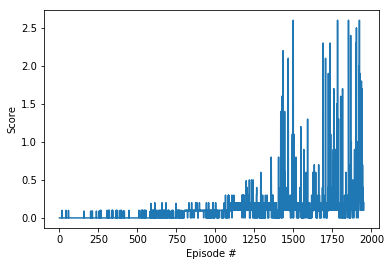

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 7. Watch the MADDPG Agent!

In the next code cell, you will load the trained weights from file to watch a the MADDPG Agent!


In [23]:
# Load trained model weights for agent1
agent1.actor_local.load_state_dict(torch.load('checkpoint_actor1.pth'))
agent1.critic_local.load_state_dict(torch.load('checkpoint_critic1.pth'))

# Load trained model weights for agent2
agent2.actor_local.load_state_dict(torch.load('checkpoint_actor2.pth'))
agent2.critic_local.load_state_dict(torch.load('checkpoint_critic2.pth'))

for i_episode in range(1, 11):

    # Reset the unity environment at the beginning of each episode
    # Set train mode to false
    env_info = env.reset(train_mode=False)[brain_name]     

    # Get initial state of the Unity ML-agents environment and reshape
    states = env_info.vector_observations
    states = np.reshape(states, (1, 48))

    # Reset the training agent for new episode
    agent1.reset()
    agent2.reset()

    # Set the initial episode scores to zero for each Unity ML-agent.
    scores = np.zeros(num_agents)

    # Run the episode loop;
    # At each loop step take an action as a function of the current state observations
    # If environment episode is done, exit loop...
    # Otherwise repeat until done == true 
    while True:
        # Determine actions for the Unity ML-agents from current sate
        actions1 = agent1.act(states, add_noise=False)
        actions2 = agent2.act(states, add_noise=False)

        # Send the actions to the Unity ML-agent in the environment and receive environment information
        actions = np.concatenate((actions1, actions2), axis=0) 
        actions = np.reshape(actions, (1, 4))
        env_info = env.step(actions)[brain_name]        

        next_states = env_info.vector_observations   # Get the next states for each Unity ML-agent in the environment
        next_states = np.reshape(next_states, (1, 48))
        rewards = env_info.rewards                   # Get the rewards for each Unity ML-agent in the environment
        dones = env_info.local_done                  # Gee if episode has finished for each Unity ML-agent in the environment

        # Set new states to current states for determining next actions
        states = next_states

        # Update episode score for each Unity ML-agent
        scores += rewards

        # If any Unity ML-agent indicates that the episode is done, 
        # then exit episode loop, to begin new episode
        if np.any(dones):
            break

    # Print current average score
    print('\nEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores), end=""))

env.close()


Episode 1	Average Score: 2.600

Episode 2	Average Score: 0.145

Episode 3	Average Score: 0.095

Episode 4	Average Score: 2.600

Episode 5	Average Score: 0.145

Episode 6	Average Score: 0.095

Episode 7	Average Score: 2.600

Episode 8	Average Score: 0.045

Episode 9	Average Score: -0.005

Episode 10	Average Score: 0.145


## Future Work

### 1. Explore the current MADDPG Algorithm

* Amend the various hyperparameters and network architecture to see if we can get your agent to solve the environment faster. 
* Once we build intuition for the hyperparameters that work well with this environment, try solving a different Unity ML-Agents task like [Soccer](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md).

### 2. Explore the MARL Algorithm with other baseline and Other approaches
* We are interested in implementing a MARL method that will be more stable with this project, so we will explore [this Github "Paper Collection of Multi-Agent Reinforcement Learning (MARL)"](https://github.com/LantaoYu/MARL-Papers/blob/master/README.md)
